In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os 
import glob
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from sklearn.datasets import make_moons


The code below just cleans up any old generated files we have from previous runs.

In [110]:
def cleanup_files(patterns):
    for pattern in patterns:
        for file_path in glob.glob(pattern):
            try:
                os.remove(file_path)
                #print(f"Deleted file: {file_path}")
            except Exception as e:
                print(f"Error deleting file {file_path}: {e}")

# Clean up old generated files
cleanup_files(["generated_data_t*.png", "two_moons_hist_*.png", "training_loss_*.png"])


### 1. Generate 2D Two-Moons Data

This section uses sklearn.datasets.make_moons to generate a 2D synthetic dataset commonly used for testing classification and generative models.

The output X is a tensor holding the 2D coordinates of the datapoints, with a shape of (2000,2), where each row represents a point (x,y).

A small amount of noise (0.05) is added to make the moons less perfectly shaped and more realistic.

The data is generated as a NumPy array and then converted into a PyTorch tensor (torch.float32) for use in the neural network.

A scatter plot visualizes the initial, clean dataset X_0
​


In [111]:
# 1. GENERATE 2D two-moons data

#2000 rows
n_samples = 2000
X, _ = make_moons(n_samples=n_samples, noise=0.05)
X = torch.tensor(X, dtype=torch.float32)


### 2. Define Diffusion Schedule

The diffusion schedule defines the hyperparameters for incrementally adding noise over T=200 steps.

T: The total number of diffusion steps (an integer scalar).

β (Noise Schedule): A (T,) tensor representing the variance of the Gaussian noise added at each step. Values are linearly spaced from 10 
−4
  to 0.02. This results in smaller noise being added at the start and larger noise near the end.

α: A (T,) tensor calculated as 1−β. It controls the portion of the previous signal retained at each step.

α_bar
  (Cumulative Product): The cumulative product of α. This is the core DDPM schedule, providing a closed-form solution to determine how much of the original clean sample (x 
0
​
 ) remains after t noising steps. It is a (T,) tensor.

In [112]:
T = 200  # number of diffusion steps
beta = torch.linspace(1e-4, 0.02, T)  # noise schedule  ##1
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0) 

### 3. Define Simple Denoising Model
The DenoiseMLP is a simple PyTorch neural network built to predict the noise ϵ in the data x_t at a given timestep t. It inherits functionality by calling the parent constructor.

#### Architecture
The network consists of three linear layers designed to process and predict the 2D data:

self.fc1: The input layer takes an input size of 3 (the 2D coordinates x 
t
​
  plus 1 time embedding) and outputs 128 features. The weights are shaped (128,3).

self.fc2: This hidden layer maps 128 input features to 128 output features.

self.fc3: The final layer takes 128 features and outputs 2D coordinates, which is the predicted noise vector ϵ_θ
​
 .

#### Forward Pass Logic
The forward(self, x, t) method processes a batch of size N, where x is the noised data (shape: (N,2)) and t is the timestep batch (shape: (N,)).

Time Embedding: The timestep t is first normalized by T (since T=200). It is then given a feature dimension using t.unsqueeze(-1), resulting in a time embedding t 
embed
​
  of shape (N,1).

Concatenation: x and t 
embed
​
  are concatenated along the feature dimension (dim=1). This combined input h has a shape of (N,3), merging the spatial and time features.

Propagation: h is passed through self.fc1 (mapping to 128 features), with a ReLU non-linearity applied. The result is passed through self.fc2 (mapping 128 to 128 features), with another ReLU applied.

Output: Finally, self.fc3 generates the output. The returned tensor has a shape of (N,2), representing the predicted noise vector for each input point.

In [113]:
class DenoiseMLP(nn.Module):
    def __init__(self):
        
        super().__init__()
        #first layer takes in 2d coords + 1 time embedding
        self.fc1 = nn.Linear(2+1, 128)  # +1 for time embedding
        #hidden, second linear layer
        self.fc2 = nn.Linear(128, 128)
        #final layer takes in 128 features, outputs 2d coords (the predicted noise)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x, t):

        t = t / T

        t_embed = t.unsqueeze(-1)

        h = torch.cat([x, t_embed], dim=1)

        h = F.relu(self.fc1(h))

        h = F.relu(self.fc2(h))

        return self.fc3(h)

Instantiate model and optimizer. Adam optimizer will update all model.parameters() with learning rate 1e-3.

In [114]:

# Instantiate model and optimizer
model = DenoiseMLP()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 4. Training Loop

The training loop iterates for a total of 2000 epochs, where an epoch is defined as one complete pass of the entire dataset through the model. During each epoch, the data is processed in batches; the batch size dictates the number of samples—which are the 2D data points—that are processed in one forward and backward pass before the model's parameters are updated by the optimizer.



In [115]:

n_epochs = 2000
epoch_losses = []
batch_size = 2000
dataset = TensorDataset(X)
dataLoader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

Steps Inside the Loop

1. Data Preparation:
* A random batch of clean data (x0) is sampled (shape: (N, 2)).
* A random timestep (t) is sampled for each data point in the batch.

2. Forward Diffusion (The Noising Step):
* True Noise (epsilon): Random Gaussian noise is generated (shape: (N, 2)). This is the true noise the model must learn to predict.
* Noising: The clean data x0 is transformed into the noisy sample xt using the forward diffusion equation. This equation combines scaled versions of x0 and the true noise epsilon based on the precomputed schedule alpha_bar_t.
* The noise component is small at small t and large at large t.

3. Prediction and Optimization:
* Predict Noise: The model is fed the noisy sample xt and its timestep t to produce the predicted noise (epsilon_theta). The model attempts to guess the exact noise that was added.
* Compute Loss: The Mean Squared Error (MSE) loss is calculated between the true noise (epsilon) and the predicted noise (epsilon_theta). A loss closer to 0 indicates a better prediction.
* Update: The optimizer clears old gradients, then computes new gradients (backpropagation), and finally updates the weights using gradient descent (Adam is used here).

In [116]:

for epoch in range(n_epochs):

    batch_losses = []

    for batch_x0 in dataLoader:
        x0 = batch_x0[0]
        current_batch_size = x0.shape[0]
        
        t = torch.randint(0, T, (current_batch_size,)).to(x0.device)  # (batch_size,)

        noise = torch.randn_like(x0)

        alpha_bar_t = alpha_bar[t].unsqueeze(-1)
        x_t = torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1-alpha_bar_t)*noise
        # Predict noise using the model
        noise_pred = model(x_t, t.float())

        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    avg_epoch_loss = sum(batch_losses) / len(batch_losses)
    epoch_losses.append(avg_epoch_loss)

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {avg_epoch_loss:.4f}")


Epoch 0, Loss: 0.9876
Epoch 200, Loss: 0.4274
Epoch 400, Loss: 0.3917
Epoch 600, Loss: 0.4063
Epoch 800, Loss: 0.4195
Epoch 1000, Loss: 0.4109
Epoch 1200, Loss: 0.3881
Epoch 1400, Loss: 0.3965
Epoch 1600, Loss: 0.3971
Epoch 1800, Loss: 0.3915


While in the training phase, we want to observe how our model progressively improves in its predictions through the loss. Let us plot the loss as a function of epoch count to see how noise predictions improve (or worsen) with successive exposure to clean data.

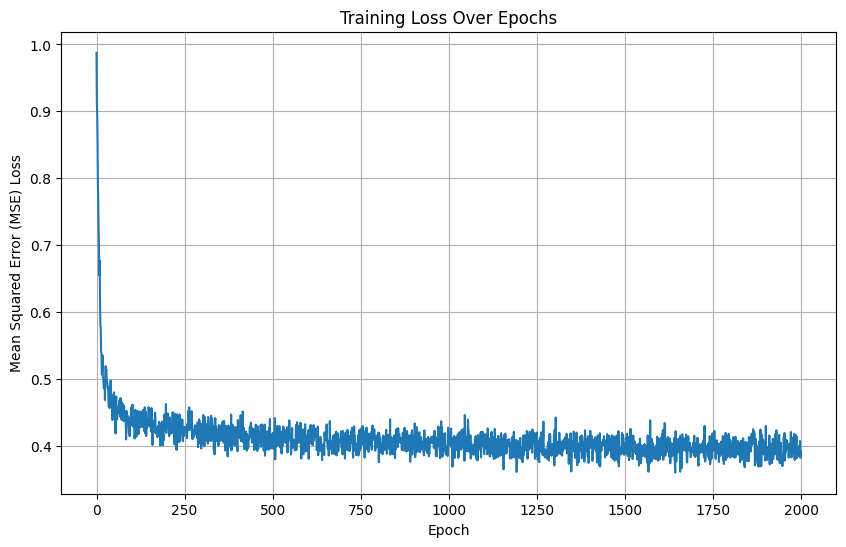

In [117]:
plt.figure(figsize=(10, 6))
# Plot the list of average epoch losses
plt.plot(range(n_epochs), epoch_losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE) Loss')
plt.grid(True)
# Save the plot with a timestamp
timestamp_loss = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f"training_loss_{timestamp_loss}.png", dpi=300)

### 5. Sampling from Learned Model

This section defines the sampling process, where the trained model generates new data by reversing the diffusion process step-by-step. Since we're generating data and not training, we use @torch.no_grad() to stop tracking gradients.

The process is defined within the 'sample' function, which begins by initializing a tensor 'x' (shape: (n_samples, 2)) with pure **standard Gaussian noise**.

Reverse Diffusion Loop

The code iterates backward through the timesteps, from T-1 down to 0:

1.  **Prepare Input**: A batch of timesteps 't_batch' is created (shape: (n_samples,)), where every entry equals the current step t.
2.  **Predict Noise**: The denoiser model is called to predict the noise component (predicted_noise) in the current sample 'x'.
3.  **Schedule Lookup**: The scalar values for the current step—alpha_t (signal retention), alpha_bar_t (cumulative retention), and beta_t (noise variance)—are indexed from the precomputed schedules.
4.  **Reverse Step (Denoising)**: The crucial step involves using the predicted noise to compute the posterior mean estimate (x_t-1). This is the algebraic reverse step that recovers a less-noisy version of 'x'. The first part of the equation scales 'x' by 1/sqrt(alpha_t) to undo the forward step's signal shrinkage.
5.  **Add Stochasticity**: For all steps where t > 0, a small amount of new Gaussian noise is added back. This noise is scaled by sqrt(beta_t). This is vital because the REVERSE PROCESS IS STOCHASTIC, NOT DETERMINISTIC, and adding noise ensures diversity in the generated samples. The last step (t=0) is left clean.

The function finally returns 'x', which is a (n_samples, 2) tensor of generated 2D points that now resemble the original two-moons data.

In [118]:
@torch.no_grad()
def sample(model, n_samples):
    x = torch.randn(n_samples, 2)  # start from pure noise
    #loop over timesteps in reverse order
    for t in reversed(range(T)):

        t_batch = torch.full((n_samples,), t, dtype=torch.float32)

        predicted_noise = model(x, t_batch)

        alpha_t = alpha[t]

        alpha_bar_t = alpha_bar[t]

        beta_t = beta[t]
        

        x = 1/torch.sqrt(alpha_t) * (x - (1-alpha_t)/torch.sqrt(1-alpha_bar_t)*predicted_noise)

        if t > 0:
            x += torch.sqrt(beta_t) * torch.randn_like(x) ###

        if t in [199, 150, 100, 50, 40, 30, 20, 15, 10, 5, 0]:
 
            plt.figure(figsize=(8,6))
            plt.hist2d(x[:,0].numpy(), x[:,1].numpy(), bins=100, density=True, cmap='viridis')
            plt.colorbar(label='Density')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(f"Generated Data at Timestep {t}")
            plt.savefig(f"generated_data_t{t}.png", dpi=300)


    return x

Finally, we generate 200000 samples using our trained MLP model.

We plot out a 2D histogram of our 200,000 samples, signed with the date and time.

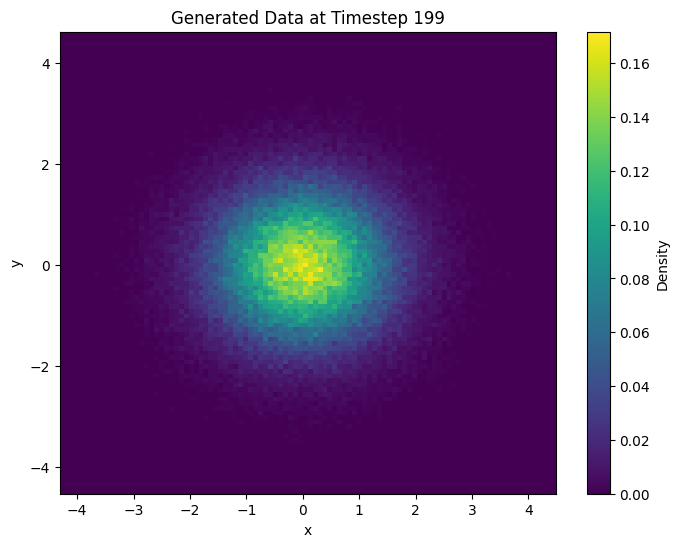

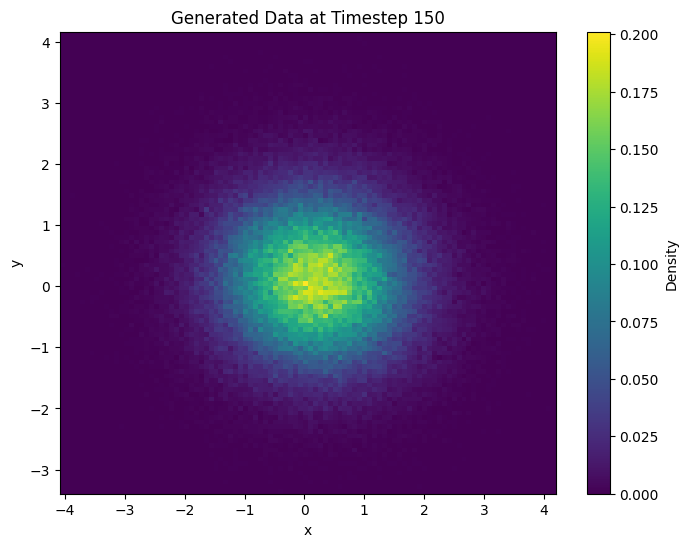

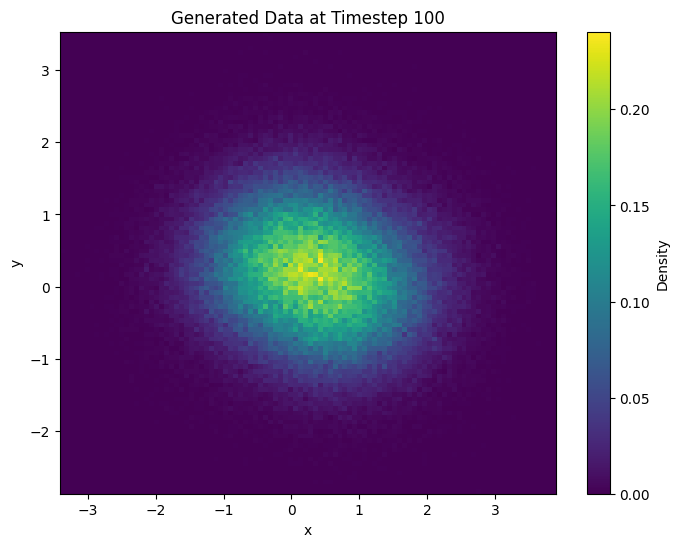

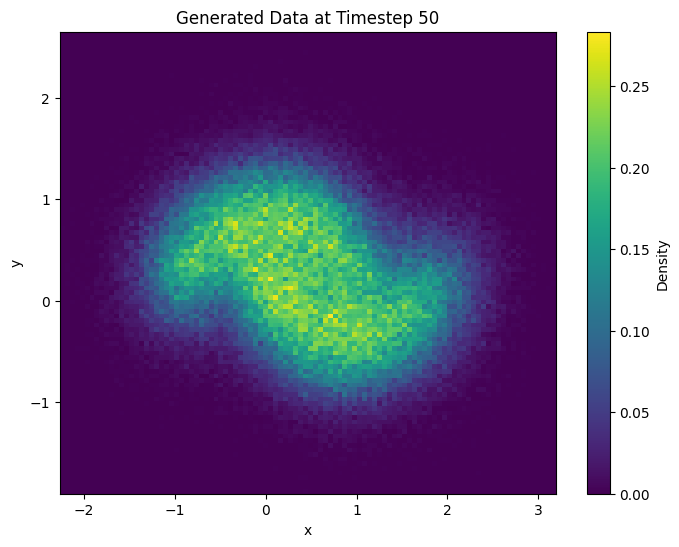

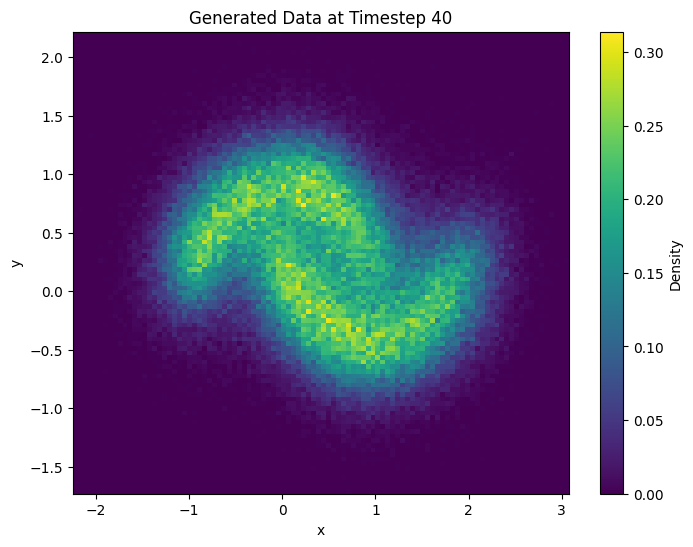

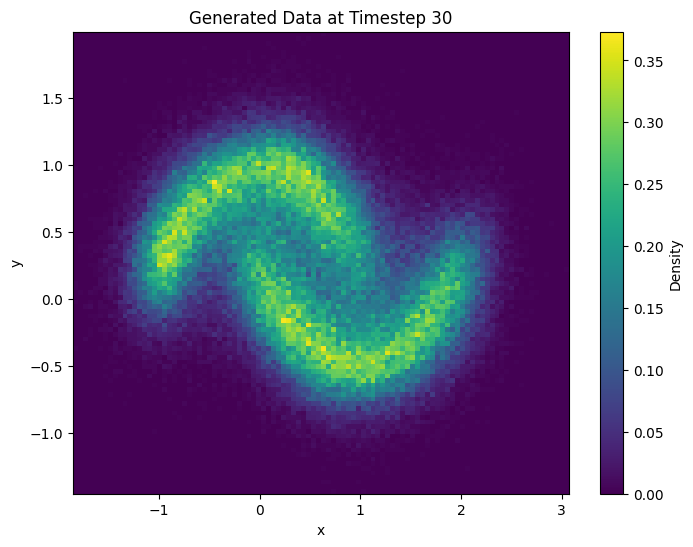

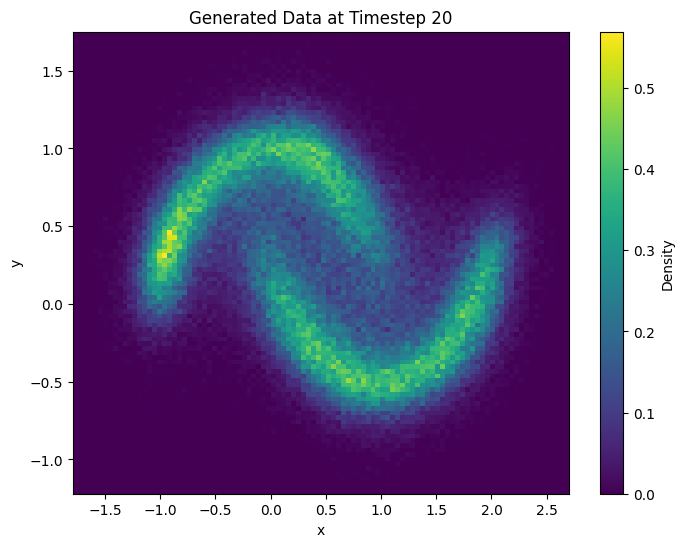

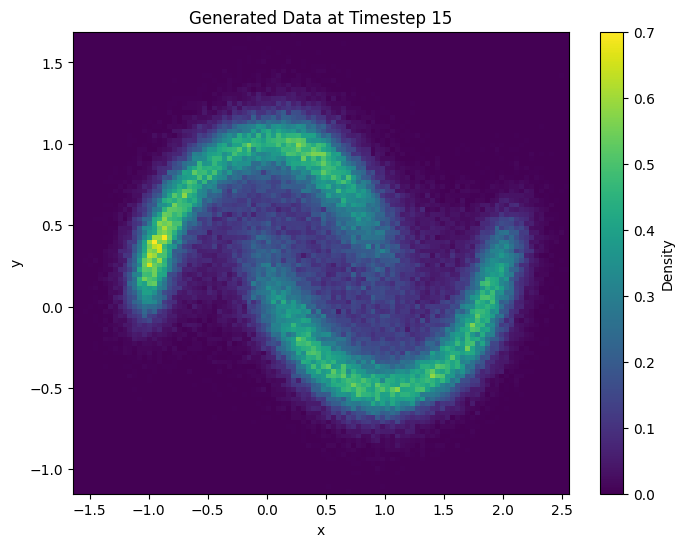

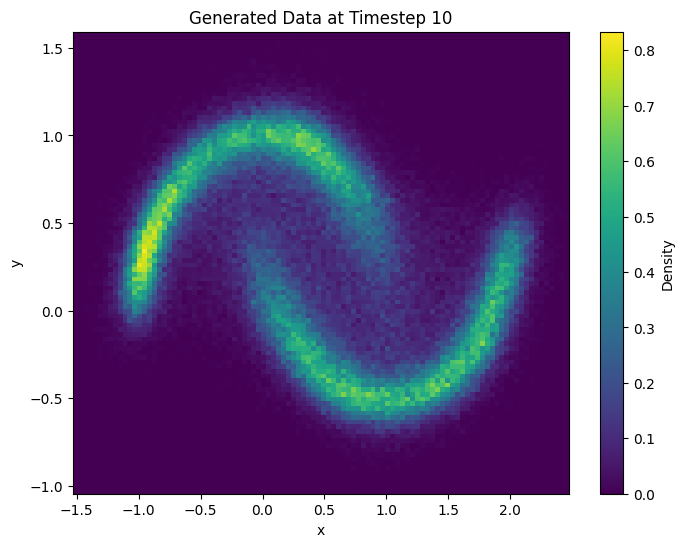

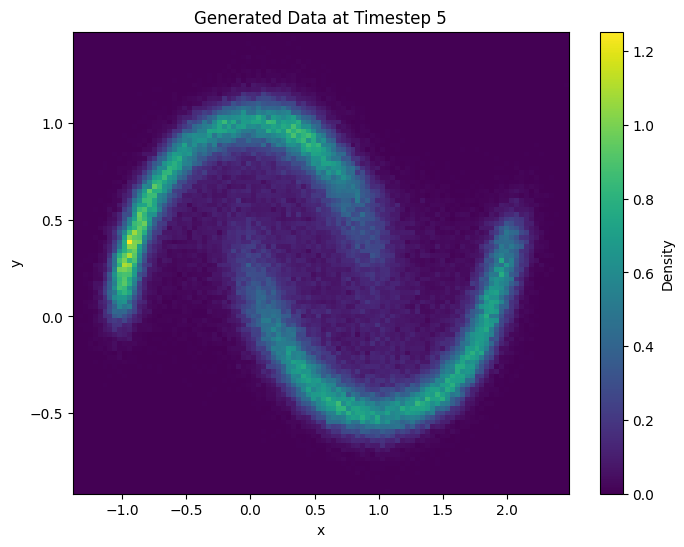

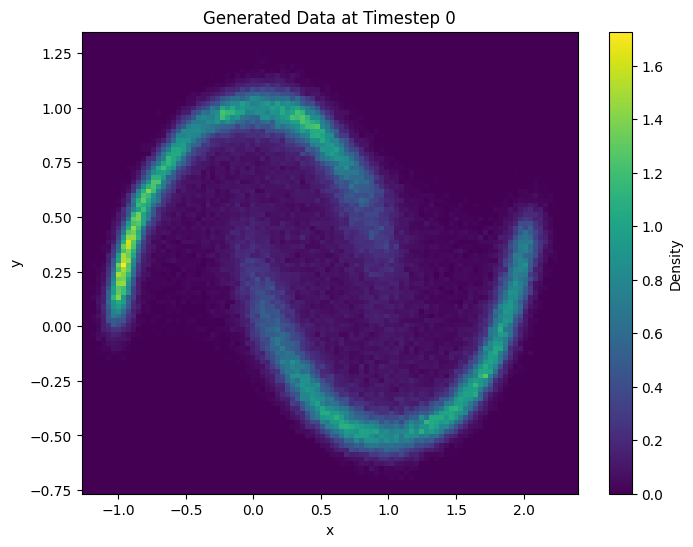

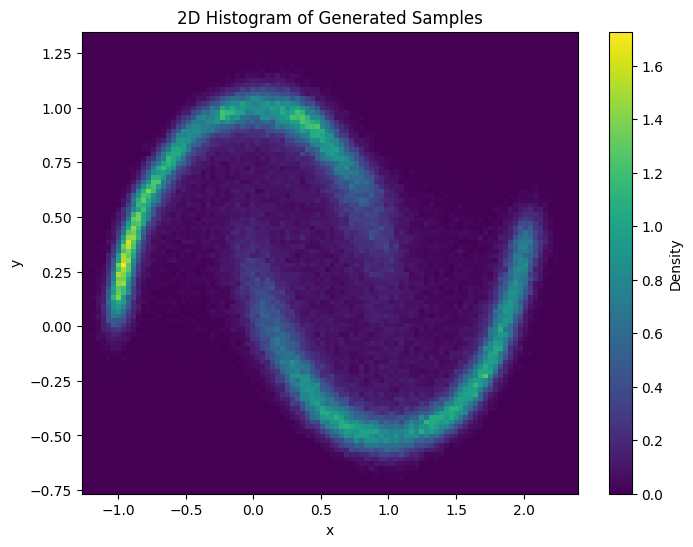

In [119]:

# Generate samples
samples = sample(model, 200000)

# 2D histogram

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

plt.figure(figsize=(8,6))
plt.hist2d(samples[:,0].numpy(), samples[:,1].numpy(), bins=100, density=True, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Histogram of Generated Samples')
plt.savefig(f"two_moons_hist_{timestamp}.png", dpi=300)